<a href="https://colab.research.google.com/github/ptah0414/stock-coin-price-prediction/blob/main/06_03_lunacoin_anomaly_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Timeseries anomaly detection using an Autoencoder



## Introduction

This script demonstrates how you can use a reconstruction convolutional
autoencoder model to detect anomalies in timeseries data.

## Setup

In [ ]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

## Load the data


In [ ]:
# !pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 63 kB 1.5 MB/s 
     |████████████████████████████████| 6.4 MB 11.1 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.27.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import yfinance as yf

In [ ]:
interval = "5m"
# valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo

In [ ]:
# 9일부터 12일 폭락함
start = "2022-04-29"
end = "2022-05-13"

In [ ]:
df = yf.download("LUNA1-USD", start=start, end=end, interval=interval)
df["close_chg"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
luna = df[["close_chg"]]
luna

[*********************100%***********************]  1 of 1 completed


,close_chg
Datetime,
2022-04-29 00:00:00+00:00,NaN
2022-04-29 00:05:00+00:00,-0.040314
2022-04-29 00:10:00+00:00,0.099108
2022-04-29 00:15:00+00:00,0.116167
2022-04-29 00:20:00+00:00,-0.054653
...,...
2022-05-12 23:35:00+00:00,2.303633
2022-05-12 23:40:00+00:00,-11.332991
2022-05-12 23:45:00+00:00,2.043528


In [ ]:
luna = luna.fillna(method = "bfill")
luna.head()

,close_chg
Datetime,
2022-04-29 00:00:00+00:00,-0.040314
2022-04-29 00:05:00+00:00,-0.040314
2022-04-29 00:10:00+00:00,0.099108
2022-04-29 00:15:00+00:00,0.116167
2022-04-29 00:20:00+00:00,-0.054653


In [ ]:
df = yf.download("BTC-USD", start=start, end=end, interval=interval)
df["close_chg"] = (df["Close"] - df["Close"].shift(1)) / df["Close"].shift(1) * 100
btc = df[["close_chg"]]
btc

[*********************100%***********************]  1 of 1 completed


,close_chg
Datetime,
2022-04-29 00:00:00+00:00,NaN
2022-04-29 00:05:00+00:00,-0.040716
2022-04-29 00:10:00+00:00,0.174312
2022-04-29 00:15:00+00:00,0.022720
2022-04-29 00:20:00+00:00,0.005424
...,...
2022-05-12 23:35:00+00:00,0.457139
2022-05-12 23:40:00+00:00,0.092091
2022-05-12 23:45:00+00:00,0.080943


In [ ]:
btc = btc.fillna(method = "bfill")
btc.head()

,close_chg
Datetime,
2022-04-29 00:00:00+00:00,-0.040716
2022-04-29 00:05:00+00:00,-0.040716
2022-04-29 00:10:00+00:00,0.174312
2022-04-29 00:15:00+00:00,0.022720
2022-04-29 00:20:00+00:00,0.005424


## Quick look at the data

In [ ]:
# print(df_small_noise.head())

# print(df_daily_jumpsup.head())

In [ ]:
print(luna.head())
print(btc.head())

                           close_chg
Datetime                            
2022-04-29 00:00:00+00:00  -0.040314
2022-04-29 00:05:00+00:00  -0.040314
2022-04-29 00:10:00+00:00   0.099108
2022-04-29 00:15:00+00:00   0.116167
2022-04-29 00:20:00+00:00  -0.054653
                           close_chg
Datetime                            
2022-04-29 00:00:00+00:00  -0.040716
2022-04-29 00:05:00+00:00  -0.040716
2022-04-29 00:10:00+00:00   0.174312
2022-04-29 00:15:00+00:00   0.022720
2022-04-29 00:20:00+00:00   0.005424


In [ ]:
df_small_noise = btc # 정상
df_daily_jumpsup = luna # 비정상

## Visualize the data
### Timeseries data without anomalies

We will use the following data for training.

In [ ]:
# # 정상 데이터(비트코인)
# fig, ax = plt.subplots()
# df_small_noise.plot(legend=False, ax=ax)
# plt.show()

### Timeseries data with anomalies

We will use the following data for testing and see if the sudden jump up in the
data is detected as an anomaly.

In [ ]:
# # 비정상 데이터(루나코인)
# fig, ax = plt.subplots()
# df_daily_jumpsup.plot(legend=False, ax=ax)
# plt.show()

##비트코인(주황) & 루나코인(파랑)

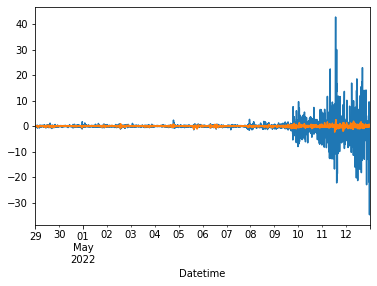

In [ ]:
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
df_small_noise.plot(legend=False, ax=ax)
plt.show()

## Prepare training data

Get data values from the training timeseries data file and normalize the
`value` data. We have a `value` for every 5 mins for 14 days.

-   24 * 60 / 5 = **288 timesteps per day**
-   288 * 14 = **4032 data points** in total

In [ ]:
# Normalize and save the mean and std we get,
# for normalizing test data.
training_mean = df_small_noise.mean()
training_std = df_small_noise.std()
df_training_value = (df_small_noise - training_mean) / training_std
print("Number of training samples:", len(df_training_value))

Number of training samples: 4032


### Create sequences
Create sequences combining `TIME_STEPS` contiguous data values from the
training data.

In [ ]:
TIME_STEPS = 288

# Generated training sequences for use in the model.
def create_sequences(values, time_steps=TIME_STEPS):
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i : (i + time_steps)])
    return np.stack(output)


x_train = create_sequences(df_training_value.values)
print("Training input shape: ", x_train.shape)

Training input shape:  (3745, 288, 1)


## Build a model

We will build a convolutional reconstruction autoencoder model. The model will
take input of shape `(batch_size, sequence_length, num_features)` and return
output of the same shape. In this case, `sequence_length` is 288 and
`num_features` is 1.

In [ ]:
model = keras.Sequential(
    [
        layers.Input(shape=(x_train.shape[1], x_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 144, 32)           256       
                                                                 
 dropout (Dropout)           (None, 144, 32)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 72, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 144, 16)          1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 144, 16)           0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 288, 32)          3616      
 ranspose)                                              

## Train the model

Please note that we are using `x_train` as both the input and the target
since this is a reconstruction model.

In [ ]:
history = model.fit(
    x_train,
    x_train,
    epochs=5,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min")
    ],
)

Epoch 1/50
27/27 [==============================] - 4s 101ms/step - loss: 0.4601 - val_loss: 2.6800
Epoch 2/50
27/27 [==============================] - 3s 115ms/step - loss: 0.2369 - val_loss: 0.8392
Epoch 3/50
27/27 [==============================] - 4s 143ms/step - loss: 0.1200 - val_loss: 0.3299
Epoch 4/50
27/27 [==============================] - 4s 153ms/step - loss: 0.0887 - val_loss: 0.2053
Epoch 5/50
27/27 [==============================] - 4s 159ms/step - loss: 0.0770 - val_loss: 0.1799
Epoch 6/50
27/27 [==============================] - 5s 179ms/step - loss: 0.0701 - val_loss: 0.1598
Epoch 7/50
27/27 [==============================] - 5s 170ms/step - loss: 0.0659 - val_loss: 0.1516
Epoch 8/50
27/27 [==============================] - 5s 188ms/step - loss: 0.0630 - val_loss: 0.1359
Epoch 9/50
27/27 [==============================] - 6s 212ms/step - loss: 0.0600 - val_loss: 0.1293
Epoch 10/50
27/27 [==============================] - 5s 196ms/step - loss: 0.0585 - val_loss: 0.1228

Let's plot training and validation loss to see how the training went.

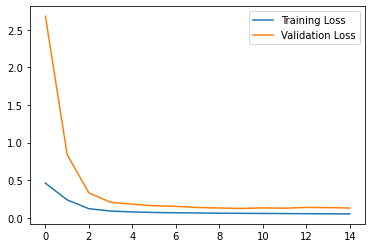

In [ ]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

## Detecting anomalies

We will detect anomalies by determining how well our model can reconstruct
the input data.


1.   Find MAE loss on training samples.
2.   Find max MAE loss value. This is the worst our model has performed trying
to reconstruct a sample. We will make this the `threshold` for anomaly
detection.
3.   If the reconstruction loss for a sample is greater than this `threshold`
value then we can infer that the model is seeing a pattern that it isn't
familiar with. We will label this sample as an `anomaly`.


#Threshold 설정

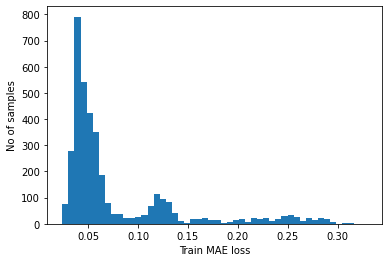

Reconstruction error threshold:  0.329198042110585


In [ ]:
# Get train MAE loss.
x_train_pred = model.predict(x_train)
train_mae_loss = np.mean(np.abs(x_train_pred - x_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

### Compare recontruction

Just for fun, let's see how our model has recontructed the first sample.
This is the 288 timesteps from day 1 of our training dataset.

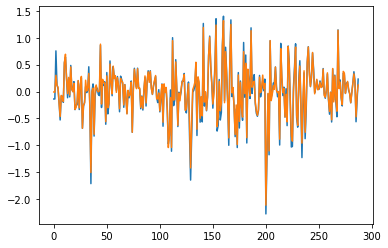

In [ ]:
# Checking how the first sequence is learnt
plt.plot(x_train[0])
plt.plot(x_train_pred[0])
plt.show()

### Prepare test data

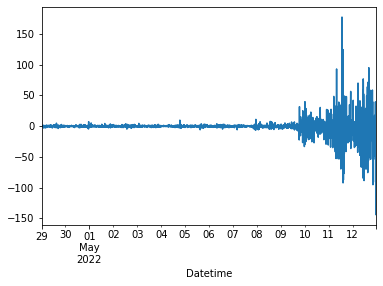

Test input shape:  (3745, 288, 1)


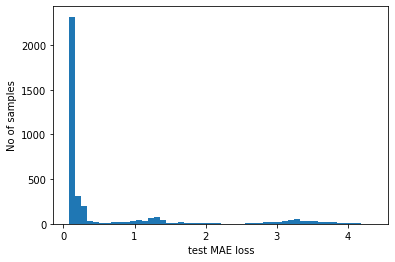

Number of anomaly samples:  915
Indices of anomaly samples:  (array([2818, 2824, 2826, 2830, 2831, 2832, 2833, 2834, 2835, 2836, 2838,
       2839, 2840, 2842, 2843, 2844, 2845, 2846, 2847, 2848, 2850, 2851,
       2852, 2853, 2854, 2855, 2856, 2857, 2858, 2859, 2860, 2861, 2862,
       2863, 2864, 2865, 2866, 2867, 2868, 2869, 2870, 2871, 2872, 2873,
       2874, 2875, 2876, 2877, 2878, 2879, 2880, 2881, 2882, 2883, 2884,
       2885, 2886, 2887, 2888, 2889, 2890, 2891, 2892, 2893, 2894, 2895,
       2896, 2897, 2898, 2899, 2900, 2901, 2902, 2903, 2904, 2905, 2906,
       2907, 2908, 2909, 2910, 2911, 2912, 2913, 2914, 2915, 2916, 2917,
       2918, 2919, 2920, 2921, 2922, 2923, 2924, 2925, 2926, 2927, 2928,
       2929, 2930, 2931, 2932, 2933, 2934, 2935, 2936, 2937, 2938, 2939,
       2940, 2941, 2942, 2943, 2944, 2945, 2946, 2947, 2948, 2949, 2950,
       2951, 2952, 2953, 2954, 2955, 2956, 2957, 2958, 2959, 2960, 2961,
       2962, 2963, 2964, 2965, 2966, 2967, 2968, 2969, 2970, 2

In [ ]:

df_test_value = (df_daily_jumpsup - training_mean) / training_std
fig, ax = plt.subplots()
df_test_value.plot(legend=False, ax=ax)
plt.show()

# Create sequences from test values.
x_test = create_sequences(df_test_value.values)
print("Test input shape: ", x_test.shape)

# Get test MAE loss.
x_test_pred = model.predict(x_test)
test_mae_loss = np.mean(np.abs(x_test_pred - x_test), axis=1)
test_mae_loss = test_mae_loss.reshape((-1))

plt.hist(test_mae_loss, bins=50)
plt.xlabel("test MAE loss")
plt.ylabel("No of samples")
plt.show()

# Detect all the samples which are anomalies.
anomalies = test_mae_loss > threshold
print("Number of anomaly samples: ", np.sum(anomalies))
print("Indices of anomaly samples: ", np.where(anomalies))

## Plot anomalies

We now know the samples of the data which are anomalies. With this, we will
find the corresponding `timestamps` from the original test data. We will be
using the following method to do that:

Let's say time_steps = 3 and we have 10 training values. Our `x_train` will
look like this:

- 0, 1, 2
- 1, 2, 3
- 2, 3, 4
- 3, 4, 5
- 4, 5, 6
- 5, 6, 7
- 6, 7, 8
- 7, 8, 9

All except the initial and the final time_steps-1 data values, will appear in
`time_steps` number of samples. So, if we know that the samples
[(3, 4, 5), (4, 5, 6), (5, 6, 7)] are anomalies, we can say that the data point
5 is an anomaly.

In [ ]:
# data i is an anomaly if samples [(i - timesteps + 1) to (i)] are anomalies
anomalous_data_indices = []
for data_idx in range(TIME_STEPS - 1, len(df_test_value) - TIME_STEPS + 1):
    if np.all(anomalies[data_idx - TIME_STEPS + 1 : data_idx]):
        anomalous_data_indices.append(data_idx)
# anomalous_data_indices

[3137,
 3138,
 3139,
 3140,
 3141,
 3142,
 3143,
 3144,
 3145,
 3146,
 3147,
 3148,
 3149,
 3150,
 3151,
 3152,
 3153,
 3154,
 3155,
 3156,
 3157,
 3158,
 3159,
 3160,
 3161,
 3162,
 3163,
 3164,
 3165,
 3166,
 3167,
 3168,
 3169,
 3170,
 3171,
 3172,
 3173,
 3174,
 3175,
 3176,
 3177,
 3178,
 3179,
 3180,
 3181,
 3182,
 3183,
 3184,
 3185,
 3186,
 3187,
 3188,
 3189,
 3190,
 3191,
 3192,
 3193,
 3194,
 3195,
 3196,
 3197,
 3198,
 3199,
 3200,
 3201,
 3202,
 3203,
 3204,
 3205,
 3206,
 3207,
 3208,
 3209,
 3210,
 3211,
 3212,
 3213,
 3214,
 3215,
 3216,
 3217,
 3218,
 3219,
 3220,
 3221,
 3222,
 3223,
 3224,
 3225,
 3226,
 3227,
 3228,
 3229,
 3230,
 3231,
 3232,
 3233,
 3234,
 3235,
 3236,
 3237,
 3238,
 3239,
 3240,
 3241,
 3242,
 3243,
 3244,
 3245,
 3246,
 3247,
 3248,
 3249,
 3250,
 3251,
 3252,
 3253,
 3254,
 3255,
 3256,
 3257,
 3258,
 3259,
 3260,
 3261,
 3262,
 3263,
 3264,
 3265,
 3266,
 3267,
 3268,
 3269,
 3270,
 3271,
 3272,
 3273,
 3274,
 3275,
 3276,
 3277,
 3278,
 3279,

Let's overlay the anomalies on the original test data plot.

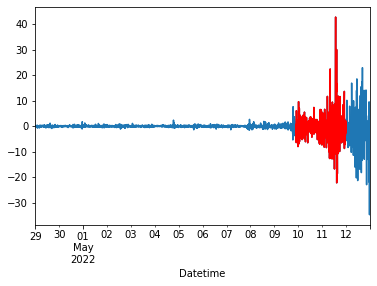

In [ ]:
df_subset = df_daily_jumpsup.iloc[anomalous_data_indices]
fig, ax = plt.subplots()
df_daily_jumpsup.plot(legend=False, ax=ax)
if anomalous_data_indices:
  df_subset.plot(legend=False, ax=ax, color="r")
plt.show()